In [1736]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Data Cleaning

In [1737]:
# load data
trn_data = pd.read_csv("train_data.csv")
test_data  = pd.read_csv("test_data.csv")


In [1738]:
# change event type to int. 1 for race, 0 for sprint.
trn_data["Event_Type"] = (trn_data["Event_Type"] == "Race").astype(int)
test_data["Event_Type"] = (test_data["Event_Type"] == "Race").astype(int)

In [1739]:
# clean NaNs
cols_to_fill = ["Sprint_Qual_Position", "Sprint_Race_Position","Sector1Time", "Sector2Time", "Sector3Time", "SpeedST", "Stint", "Race_Position"]
trn_data[cols_to_fill] = trn_data[cols_to_fill].fillna(-1)

test_data[cols_to_fill] = test_data[cols_to_fill].fillna(-1)

# have to think if this is the right way to do this



In [1740]:
def check_teams():
    unique_teams_pre_2025 = trn_data["TeamName"].unique()
    unique_teams_pre_2025.sort()
    unique_teams_2025 = test_data["TeamName"].unique()
    unique_teams_2025.sort()
    print(unique_teams_pre_2025)
    print(unique_teams_2025)

    teams_2025 = set(unique_teams_2025)
    unknown_teams = []
    for team in unique_teams_pre_2025: 
        if team not in teams_2025:
            unknown_teams.append(team)
    print(f"Unknown Teams: {unknown_teams}")

check_teams()

['Alfa Romeo' 'AlphaTauri' 'Alpine' 'Aston Martin' 'Ferrari'
 'Haas F1 Team' 'Kick Sauber' 'McLaren' 'Mercedes' 'RB' 'Red Bull Racing'
 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: ['Alfa Romeo', 'AlphaTauri', 'RB']


In [1741]:
# edit pre 2025 teams to match 2025 teams. 
# alphatauri == RB == Racing Bulls
# alfa romeo == kick sauber

trn_data.loc[(trn_data["TeamName"] == "AlphaTauri") | (trn_data["TeamName"] == "RB"), "TeamName"] = "Racing Bulls"
trn_data.loc[(trn_data["TeamName"] == "Alfa Romeo"), "TeamName"] = "Kick Sauber"
check_teams()


['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: []


In [1742]:
unique_teams = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_teams = unique_teams["TeamName"].unique()
len(unique_teams)

10

In [1743]:
unique_teams

array(['Red Bull Racing', 'Racing Bulls', 'Alpine', 'Ferrari',
       'Aston Martin', 'Haas F1 Team', 'Williams', 'Kick Sauber',
       'McLaren', 'Mercedes'], dtype=object)

In [1744]:
def get_all_drivers():
    all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
    all_drivers = all_drivers.groupby("DriverNumber")["BroadcastName"].unique().apply(list).to_dict()
    return all_drivers

# issues found here: 1) driver number not unqiue (e.g. two diff drivers can share the same driver number in history) 2) one driver can have multiple driver numbers through history.
# Soln: need to create a bijection. By taking all the unique driver names and creating your own mapping or just one hot encoding? 

In [1745]:
# code to get rid of nan values for driver broadcast name
all_drivers = get_all_drivers()
trn_data.iloc[35,1] = all_drivers[trn_data.iloc[35,0]][0]
trn_data.iloc[725,1] = all_drivers[trn_data.iloc[725,0]][0]

# fix 'A ANTONELLI', 'K ANTONELLI'
test_data.iloc[2,1] = 'K ANTONELLI'

In [1746]:
trn_data[trn_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [1747]:
test_data[test_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [1748]:
test_data.loc[test_data["DriverNumber"]==12,:]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position
2,12,K ANTONELLI,Mercedes,1,Australia,Melbourne,2025,1,-1.0,-1.0,16.0,36.392589,23.503333,47.519421,255.947368,6.0,4.0
22,12,K ANTONELLI,Mercedes,2,China,Shanghai,2025,0,7.0,7.0,8.0,26.524509,29.694607,42.096607,319.732143,2.0,6.0
42,12,K ANTONELLI,Mercedes,3,Japan,Suzuka,2025,1,-1.0,-1.0,6.0,32.952885,42.184377,18.081623,298.924528,2.0,6.0
62,12,K ANTONELLI,Mercedes,4,Bahrain,Sakhir,2025,1,-1.0,-1.0,4.0,32.644768,43.987333,24.861965,308.678571,4.0,11.0
82,12,K ANTONELLI,Mercedes,5,Saudi Arabia,Jeddah,2025,1,-1.0,-1.0,5.0,36.267633,30.152100,31.564760,304.000000,2.0,6.0


In [1749]:
# issue 1 with driver numbers

drivers = get_all_drivers()
for key in drivers:
    if len(drivers[key]) > 1: print(f"{key}:{drivers[key]}")


5:['S VETTEL', 'G BORTOLETO']
6:['N LATIFI', 'I HADJAR']


In [1750]:
# issue 2 with driver numbers 

arr_from_drivers = []
for key in drivers: 
    for driver in drivers[key]: 
        arr_from_drivers.append(driver)

arr_from_drivers.sort()

from collections import Counter
counts = Counter(arr_from_drivers)

# Filter duplicates
duplicates = {item: count for item, count in counts.items() if count > 1}

print(duplicates)

{'J DOOHAN': 2, 'L LAWSON': 2, 'N DE VRIES': 2, 'O BEARMAN': 3}


In [1751]:
all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_driver_names = all_drivers["BroadcastName"].unique()
unique_driver_names.sort()
len(unique_driver_names)


31

In [1752]:
unique_driver_names

array(['A ALBON', 'C LECLERC', 'C SAINZ', 'D RICCIARDO', 'E OCON',
       'F ALONSO', 'F COLAPINTO', 'G BORTOLETO', 'G RUSSELL', 'G ZHOU',
       'I HADJAR', 'J DOOHAN', 'K ANTONELLI', 'K MAGNUSSEN', 'L HAMILTON',
       'L LAWSON', 'L NORRIS', 'L SARGEANT', 'L STROLL', 'M SCHUMACHER',
       'M VERSTAPPEN', 'N DE VRIES', 'N HULKENBERG', 'N LATIFI',
       'O BEARMAN', 'O PIASTRI', 'P GASLY', 'S PEREZ', 'S VETTEL',
       'V BOTTAS', 'Y TSUNODA'], dtype=object)

In [1753]:
unique_locations = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_locations = unique_locations["Location"].unique()
len(unique_locations)

25

In [1754]:
unique_locations

array(['Sakhir', 'Jeddah', 'Melbourne', 'Imola', 'Miami', 'Barcelona',
       'Monaco', 'Baku', 'Montréal', 'Silverstone', 'Spielberg',
       'Le Castellet', 'Budapest', 'Spa-Francorchamps', 'Zandvoort',
       'Monza', 'Marina Bay', 'Suzuka', 'Austin', 'Mexico City',
       'São Paulo', 'Yas Island', 'Lusail', 'Las Vegas', 'Shanghai'],
      dtype=object)

In [1755]:
# one hot encode: driver, team, circuit, year

# have to concatenate data so that one hot encoding is aligned across train and test dataset 
data = pd.concat([trn_data,test_data], axis=0, ignore_index=True)
data = pd.get_dummies(data,columns=['TeamName'], drop_first=True)
data = pd.get_dummies(data,columns=['Location'], drop_first=True) # maybe don't one hot encode location. might just add noise. test with it first then see how dropping it changes. 




### Data Exploration

In [1756]:
data.loc[:,["DriverNumber","BroadcastName"]].iloc[0:20,:]

,DriverNumber,BroadcastName
0,1,M VERSTAPPEN
1,10,P GASLY
2,11,S PEREZ
3,14,F ALONSO
4,16,C LECLERC
5,18,L STROLL
6,20,K MAGNUSSEN
7,22,Y TSUNODA
8,23,A ALBON
9,24,G ZHOU


In [1757]:
def plt_race_positions(driverNumbers):
    df = pd.DataFrame()
    plt.figure(figsize=(20,10))
    colors = ["red","blue","green"]
    color_idx = 0
    for driver in driverNumbers:
        y = data.loc[data["DriverNumber"]==driver,["Race_Position"]]
        name = data.loc[data["DriverNumber"]==driver,["BroadcastName"]].iloc[0,0]
        x = [i for i in range(1,len(y)+1,1)]
        plt.plot(x,y,color=colors[color_idx],label=name)
        color_idx+=1
    
    plt.legend()
    plt.show()

        

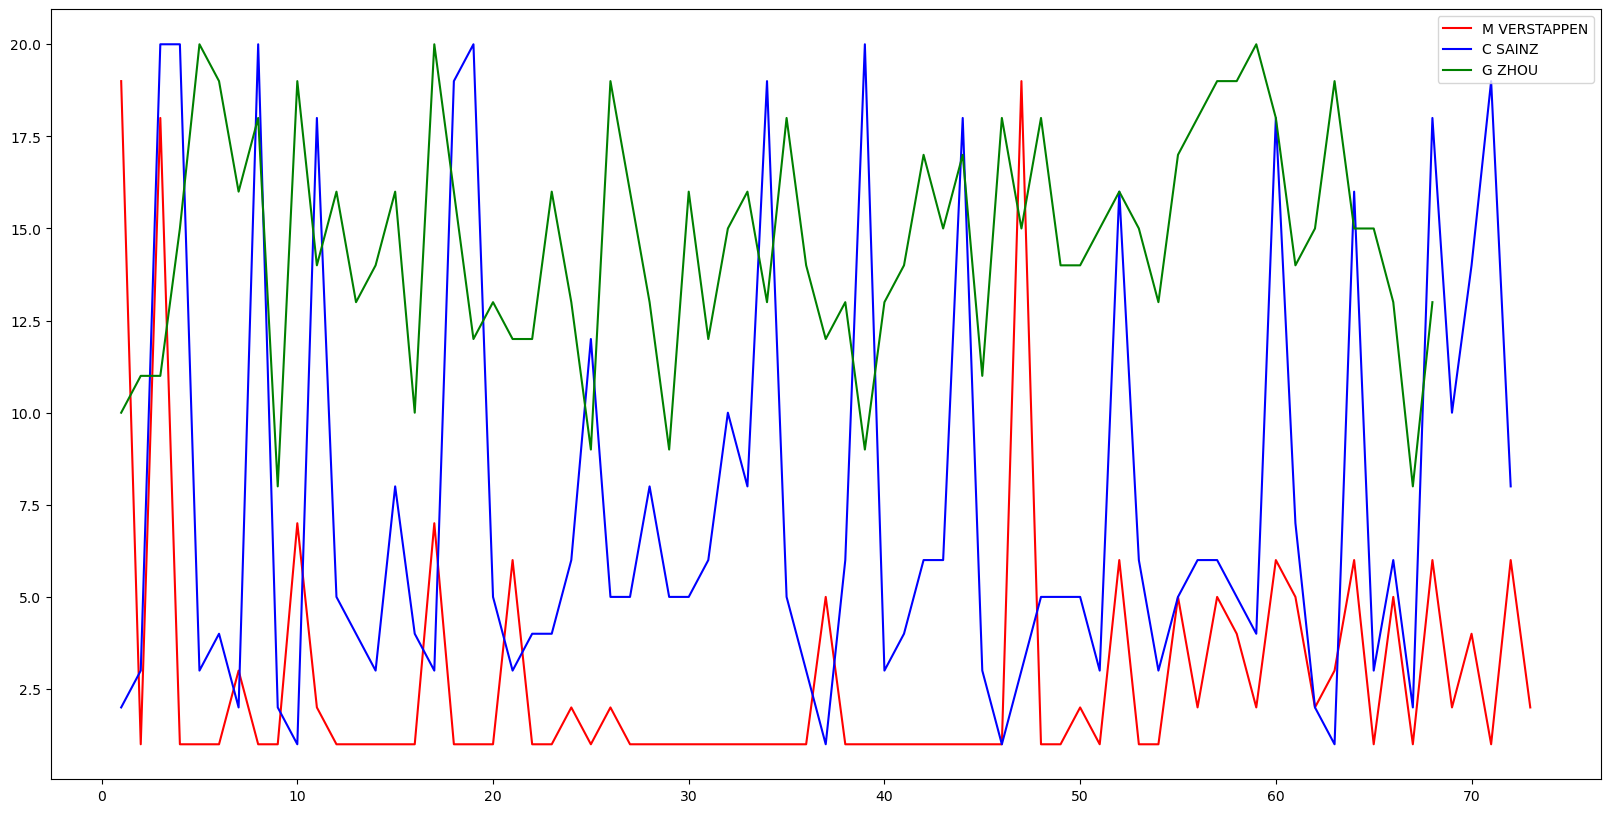

In [1758]:
plt_race_positions([1,55,24])

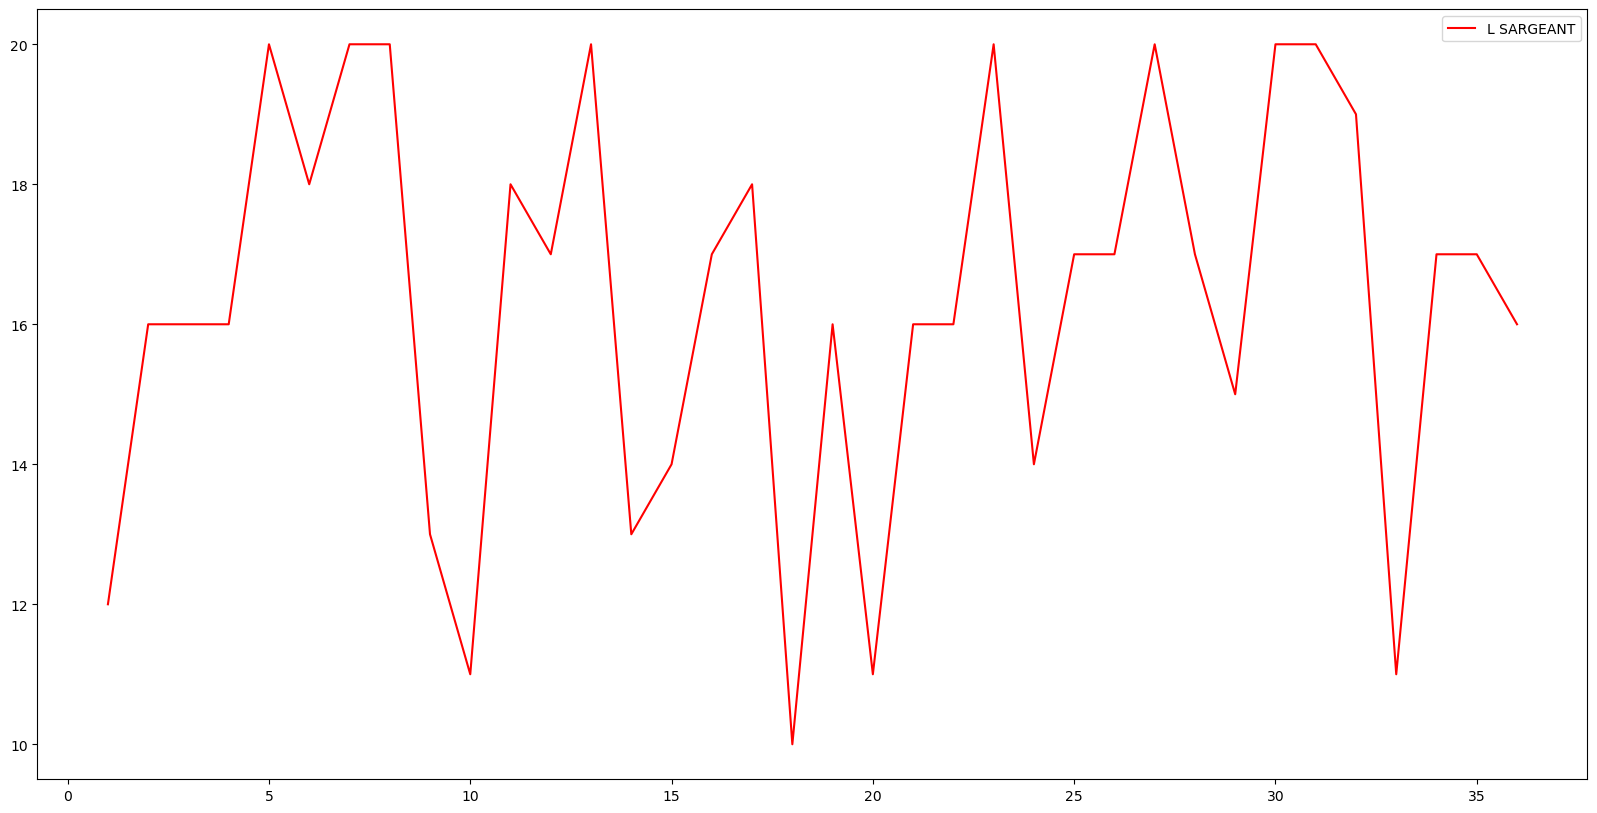

In [1759]:
plt_race_positions([2])

In [1760]:
# check balance of target
data["Race_Position"].value_counts()

 19.0    73
 14.0    73
 6.0     73
 4.0     73
 16.0    73
 2.0     73
 11.0    73
 3.0     73
 15.0    73
 7.0     73
 17.0    73
 10.0    73
 13.0    73
 8.0     73
 5.0     73
 12.0    73
 1.0     73
 9.0     73
 18.0    73
 20.0    70
-1.0      2
Name: Race_Position, dtype: int64

### Feature Engineering

come up with equaton for pos gained. shouldbn't penalize thos in top 5 that gain very few because they stayed in the top 5. need to balance that.

create mean average data for rookies in 2025

In [1761]:
# Create Race_Date_Code feature, to sort chornologically for lagging calculations
data['Race_Date_Code'] = data['Year']*100 + data['Round_Number']

In [1762]:
# Calculate Driver Encoding Feature 

data = data.sort_values(['BroadcastName','Race_Date_Code']) 
data['n_past']  = data.groupby('BroadcastName').cumcount() # number of past races up to t-1
#data['sum_past'] = data.groupby('BroadcastName')['Race_Position'].cumsum() - data['Race_Position']
#data['avg_past'] = data['sum_past'] / data['n_past']

mu = data['Race_Position'].mean() # global mean 
k  = 20 # smoothing parameter (defines the number of races needed to be considered not a rookie)
alpha = 0.3 # EMA smoothing factor. means alpha% weight on the most recent race i.e. St = alpha * xt + (1-alpha) * St-1

data['ema_past'] = (
    data
    .groupby('BroadcastName',group_keys=False)['Race_Position']
    .apply(lambda x: x.shift(1).ewm(alpha=alpha, adjust=True).mean())
)

# exponential weighted average of historice race positions
# this encoding reflects both the drivers recent form and the uncertainty that comes if they've only raced a little
data['driver_encoding'] = (data['n_past'] * data['ema_past'] + k  * mu) / (data['n_past'] + k)



In [1763]:
"""

# correct weight w_c = n_i / (n_i + k)
data['w_c']   = data['n_past'] / (data['n_past'] + k)

# 1 − w_c
data['1_minus_wc'] = 1 - data['w_c']

# weighted parts 
data['driver_avg_w'] = data['w_c'] * data['avg_past'] 
data['global_avg_w'] = data['1_minus_wc'] * mu

data['driver_encoding'] = data['driver_avg_w'] + data['global_avg_w']


#driver_stats['shrunken_avg'] = (driver_stats['n_races'] * driver_stats['avg_pos'] + k * mu) / (driver_stats['n_races'] + k) # bayesian shrinkage. Essentially just a weighted average of avg_pos
# if n_races >>> k, trust the driver's avg_pos
# if n_races <<< k, trust the global mean more
"""


"\n\n# correct weight w_c = n_i / (n_i + k)\ndata['w_c']   = data['n_past'] / (data['n_past'] + k)\n\n# 1 − w_c\ndata['1_minus_wc'] = 1 - data['w_c']\n\n# weighted parts \ndata['driver_avg_w'] = data['w_c'] * data['avg_past'] \ndata['global_avg_w'] = data['1_minus_wc'] * mu\n\ndata['driver_encoding'] = data['driver_avg_w'] + data['global_avg_w']\n\n\n#driver_stats['shrunken_avg'] = (driver_stats['n_races'] * driver_stats['avg_pos'] + k * mu) / (driver_stats['n_races'] + k) # bayesian shrinkage. Essentially just a weighted average of avg_pos\n# if n_races >>> k, trust the driver's avg_pos\n# if n_races <<< k, trust the global mean more\n"

In [1764]:
# last driver encoding for each driver
driver_last = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['driver_encoding']
      .last()
      .reset_index()
)
driver_last.sort_values(by='driver_encoding', inplace=True)
driver_last

,BroadcastName,driver_encoding
16,L NORRIS,4.480342
8,G RUSSELL,4.964024
20,M VERSTAPPEN,5.193609
25,O PIASTRI,5.554338
1,C LECLERC,7.179166
14,L HAMILTON,8.912588
12,K ANTONELLI,10.004438
24,O BEARMAN,10.388234
0,A ALBON,10.569195
28,S VETTEL,10.706482


In [1765]:
# num of races for each driver
num_races = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['n_past']
      .last()
      .reset_index()
)
num_races.sort_values(by='n_past',inplace=True)
num_races

,BroadcastName,n_past
12,K ANTONELLI,4
7,G BORTOLETO,4
10,I HADJAR,4
11,J DOOHAN,5
24,O BEARMAN,7
6,F COLAPINTO,8
21,N DE VRIES,10
15,L LAWSON,15
28,S VETTEL,19
19,M SCHUMACHER,21


In [1766]:
nan_any = data[data.isna().any(axis=1)]
if (len(nan_any) != len(unique_driver_names)): raise Exception('More NaN rows than expected after lag operation')

In [1767]:
data.drop(columns=["ema_past","n_past"],inplace=True) # drop cols used to calculate driver encoding
data = data.sort_values(['Race_Date_Code']) # reorder data chronologically

In [1768]:
# lag race features to prevent info leakage

data = data.sort_values(['BroadcastName','Race_Date_Code'])

# use weighted average of past 2 race data
def lag_feature(feature,alpha=0.6):
    return (alpha) * data.groupby('BroadcastName')[feature].shift(1) + (1-alpha) * data.groupby('BroadcastName')[feature].shift(2)

# create new features
data['lag_Sector1Time'] = lag_feature('Sector1Time')
data['lag_Sector2Time'] = lag_feature('Sector2Time')
data['lag_Sector3Time'] = lag_feature('Sector3Time')
data['lag_SpeedST'] = lag_feature('SpeedST')
data["lag_stint"] = lag_feature('Stint',0.5)

data = data.sort_values(['Race_Date_Code']) # reorder data chronologically


In [1769]:
nan_any = data[data.isna().any(axis=1)]

# note that these are the rows you will be taking from the test set.
nan_any.loc[nan_any["Year"]==2025,:]

,DriverNumber,BroadcastName,Round_Number,Country,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,...,Location_São Paulo,Location_Yas Island,Location_Zandvoort,Race_Date_Code,driver_encoding,lag_Sector1Time,lag_Sector2Time,lag_Sector3Time,lag_SpeedST,lag_stint
1372,5,G BORTOLETO,1,Australia,2025,1,-1.0,-1.0,15.0,36.537273,...,0,0,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1376,7,J DOOHAN,1,Australia,2025,1,-1.0,-1.0,14.0,-1.000000,...,0,0,0,202501,10.680668,NaN,NaN,NaN,NaN,NaN
1374,6,I HADJAR,1,Australia,2025,1,-1.0,-1.0,11.0,-1.000000,...,0,0,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1361,12,K ANTONELLI,1,Australia,2025,1,-1.0,-1.0,16.0,36.392589,...,0,0,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1392,5,G BORTOLETO,2,China,2025,0,14.0,18.0,19.0,26.910500,...,0,0,0,202502,10.728287,NaN,NaN,NaN,NaN,NaN
1394,6,I HADJAR,2,China,2025,0,15.0,13.0,7.0,26.815382,...,0,0,0,202502,10.918764,NaN,NaN,NaN,NaN,NaN
1381,12,K ANTONELLI,2,China,2025,0,7.0,7.0,8.0,26.524509,...,0,0,0,202502,10.156859,NaN,NaN,NaN,NaN,NaN


In [1770]:
# drop rows that have NaN values as a result of the lagging
# ensure that we have the correct amount of NaN values
if (len(nan_any) != 2*len(unique_driver_names)): raise Exception('More NaN rows than expected after lag operation')
data = data.dropna()
data = data.reset_index(drop=True) # reset index after dropping rows

In [1771]:
# check num races remanining after deleting lagged NaN rows

data['n_past']  = data.groupby('BroadcastName').cumcount()
num_races_remaining = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['n_past']
      .last()
      .reset_index()
)
num_races_remaining.sort_values(by='n_past',inplace=True)
num_races_remaining.head(10)

,BroadcastName,n_past
12,K ANTONELLI,2
7,G BORTOLETO,2
10,I HADJAR,2
11,J DOOHAN,3
24,O BEARMAN,5
6,F COLAPINTO,6
21,N DE VRIES,8
15,L LAWSON,13
28,S VETTEL,17
19,M SCHUMACHER,19


In [1772]:
# Encode Round + Year in [0,1]. 1 being the most recent race
min_code = data['Race_Date_Code'].min()
max_code = data['Race_Date_Code'].max()
data['Race_Date_Code'] = (data['Race_Date_Code'] - min_code) / (max_code - min_code)

In [1773]:
# ensure data is still sorted chronologically
data = data.sort_values(['Race_Date_Code']) 

In [1774]:
# split data again for training
trn_data = data.loc[data["Year"]!=2025,:]
test_data = data.loc[data["Year"]==2025,:]

### Training

In [1775]:
# Drop cols but save certain features for later during evaluation to re build dataset

trn_country = trn_data["Country"]

columns_to_drop = ["DriverNumber","Country","Sector1Time","Sector2Time","Sector3Time","SpeedST","Stint","n_past"]

trn_data = trn_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

trn_driver = trn_data["BroadcastName"]

trn_data = trn_data.drop(columns=["BroadcastName"])
test_data = test_data.drop(columns=["BroadcastName"])

trn_round_number = trn_data["Round_Number"]

In [1776]:
# split train and val
data = trn_data
val_mask = (data["Year"] == 2024) & (data["Round_Number"] > 12)

val_data = data[val_mask]
trn_data = data[~val_mask]

val_country = trn_country[val_mask]
val_driver = trn_driver[val_mask]
val_round_number = trn_round_number[val_mask]

In [1777]:
# Drop last col
cols_to_drop = ["Round_Number","Year"]
trn_data = trn_data.drop(columns=cols_to_drop, axis=1)
val_data = val_data.drop(columns=cols_to_drop, axis=1)
test_data = test_data.drop(columns=cols_to_drop, axis=1)

In [1778]:
# split features and target for each dataset 
y_trn = trn_data["Race_Position"]
x_trn = trn_data.drop(columns=["Race_Position"])

y_val = val_data["Race_Position"]
x_val = val_data.drop(columns=["Race_Position"])

y_test = test_data["Race_Position"]
x_test = test_data.drop(columns=["Race_Position"])

In [1779]:
# Confirm shapes of data
print(x_trn.shape,y_trn.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape, y_test.shape)

(1068, 44) (1068,)
(236, 44) (236,)
(93, 44) (93,)


In [1780]:
# Tune hyperparameters

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

from sklearn.model_selection import GridSearchCV, KFold
params = {"n_estimators":[10, 20, 50, 100, 120, 150]}
cv = KFold(n_splits=4, shuffle=False)
grid_search = GridSearchCV(estimator=model,param_grid=params,return_train_score=True, cv=cv).fit(x_val,y_val)
result = pd.DataFrame(grid_search.cv_results_)


In [1781]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.063976,0.045423,0.007810,0.007111,10,{'n_estimators': 10},0.658218,0.540496,0.375657,0.387644,0.490504,0.116616,5,0.895580,0.898050,0.911205,0.929432,0.908567,0.013431
1,0.054890,0.003753,0.004267,0.001070,20,{'n_estimators': 20},0.682619,0.493239,0.378473,0.357045,0.477844,0.129070,6,0.912025,0.925639,0.928938,0.920777,0.921845,0.006369
2,0.148565,0.018373,0.007946,0.002252,50,{'n_estimators': 50},0.659024,0.535478,0.383216,0.423964,0.500421,0.107199,1,0.928603,0.929544,0.933117,0.927264,0.929632,0.002169
3,0.248450,0.008351,0.009393,0.000987,100,{'n_estimators': 100},0.639482,0.532766,0.390063,0.406173,0.492121,0.101452,3,0.925063,0.930810,0.932107,0.936295,0.931069,0.004016
4,0.345211,0.036575,0.013346,0.001333,120,{'n_estimators': 120},0.668700,0.508546,0.381008,0.404669,0.490731,0.113398,4,0.922761,0.929401,0.932328,0.933317,0.929452,0.004123
5,0.401331,0.019977,0.014095,0.001638,150,{'n_estimators': 150},0.663195,0.519957,0.409811,0.407039,0.500000,0.104650,2,0.923707,0.931818,0.935589,0.935045,0.931540,0.004747


In [1782]:
best_n_estimators = result.loc[result["rank_test_score"] == 1, "param_n_estimators"].iloc[0]
best_n_estimators

50

In [1783]:
# train model
rf = RandomForestRegressor(n_estimators=best_n_estimators)
rf.fit(x_trn,y_trn)

RandomForestRegressor(n_estimators=50)

In [1784]:
x_trn

,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,TeamName_Aston Martin,TeamName_Ferrari,TeamName_Haas F1 Team,TeamName_Kick Sauber,TeamName_McLaren,TeamName_Mercedes,...,Location_São Paulo,Location_Yas Island,Location_Zandvoort,Race_Date_Code,driver_encoding,lag_Sector1Time,lag_Sector2Time,lag_Sector3Time,lag_SpeedST,lag_stint
0,1,-1.0,-1.0,1.0,0,1,0,0,0,0,...,0,0,0,0.000000,9.657750,35.488179,36.569632,29.738823,279.027304,3.0
18,1,-1.0,-1.0,14.0,0,0,0,1,0,0,...,0,0,0,0.000000,10.475932,36.085941,37.155161,29.575938,288.654769,3.5
17,1,-1.0,-1.0,5.0,0,0,0,0,0,1,...,0,0,0,0.000000,10.160424,35.714132,37.009134,29.949816,286.900511,3.0
16,1,-1.0,-1.0,12.0,0,0,0,1,0,0,...,0,0,0,0.000000,10.540103,36.243813,37.226864,30.293332,289.016667,3.5
15,1,-1.0,-1.0,3.0,0,0,0,0,0,0,...,0,0,0,0.000000,10.401066,35.514990,36.690157,29.813258,287.374792,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,1,-1.0,-1.0,11.0,0,1,0,0,0,0,...,0,0,0,0.692053,8.723071,20.831119,32.044384,22.678424,305.101513,4.0
1053,1,-1.0,-1.0,8.0,1,0,0,0,0,0,...,0,0,0,0.692053,11.763289,20.747506,32.512875,22.911617,301.652804,3.0
1054,1,-1.0,-1.0,3.0,0,0,0,0,1,0,...,0,0,0,0.692053,8.553597,20.464178,31.883422,22.782145,302.263730,3.0
1055,1,-1.0,-1.0,12.0,0,0,0,0,0,0,...,0,0,0,0.692053,15.435537,21.209068,32.684656,23.257764,298.102676,3.5


In [ ]:
# do feature importance ranking

importances = rf.feature_importances_  

# tie back to feature names
feature_importance_df = pd.DataFrame({
    'feature': x_trn.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df.loc[feature_importance_df["importance"]>=0.01].reset_index(drop=True)

,feature,importance
0,Qual_Position,0.417640
1,driver_encoding,0.140484
2,lag_Sector3Time,0.059116
3,lag_SpeedST,0.053408
4,lag_Sector2Time,0.046932
5,lag_Sector1Time,0.046268
6,Race_Date_Code,0.038252
7,TeamName_Red Bull Racing,0.030449
8,lag_stint,0.026636
9,Sprint_Qual_Position,0.011325


In [1807]:
def get_rf_metrics(y_pred,y_truth):
    from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix

    #y_pred = np.rint(y_pred).astype(int)
    y_pred = np.clip(y_pred, 1, 20)

    accuracy = accuracy_score(y_truth, y_pred)
    mae = mean_absolute_error(y_truth, y_pred)
    cm = confusion_matrix(y_truth, y_pred)

    print(f"Accuracy (exact position match): {accuracy:.3f}")
    print(f"Mean absolute error in positions: {mae:.3f}")
    print("Confusion matrix:\n", cm)

In [1808]:
y_pred = rf.predict(x_val)
y_pred_rounded = np.rint(y_pred).astype(int)
len(y_pred)

236

In [1809]:
get_rf_metrics(y_pred_rounded,y_val)

Accuracy (exact position match): 0.127
Mean absolute error in positions: 3.496
Confusion matrix:
 [[0 0 0 1 0 3 4 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 3 0 5 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 2 2 0 3 2 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 2 1 3 0 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 3 1 1 2 0 1 1 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 1 4 0 2 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 3 2 2 2 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 0 5 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 2 2 5 0 1 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 1 1 0 2 1 3 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 2 3 0 2 2 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 1 3 3 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 1 1 4 1 2 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 1 5 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 2 5 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 2 5 1 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 4 1 2 1 0 2 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 3 3 3 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 1 3 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 1 1 1 3 0 4 0 0 0 0 0]]


In [1810]:
val_copy = x_val.copy()
val_copy["Round_Number"] = val_round_number
val_copy["Driver"] = val_driver
val_copy["Country"] = val_country
val_copy["Predicted_Race_Position"] = y_pred_rounded
val_copy["Race_Position"] = y_val

In [1811]:
# look at your predictions for max verstappen races in val set vs predicted race position
val_copy.loc[val_copy["Driver"]=='M VERSTAPPEN',:]

,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,TeamName_Aston Martin,TeamName_Ferrari,TeamName_Haas F1 Team,TeamName_Kick Sauber,TeamName_McLaren,TeamName_Mercedes,...,lag_Sector1Time,lag_Sector2Time,lag_Sector3Time,lag_SpeedST,lag_stint,Round_Number,Driver,Country,Predicted_Race_Position,Race_Position
1087,1,-1.0,-1.0,3.0,0,0,0,0,0,0,...,26.058454,35.473177,24.211810,295.728494,3.5,13,M VERSTAPPEN,Hungary,3,5.0
1105,1,-1.0,-1.0,1.0,0,0,0,0,0,0,...,30.746147,33.222943,24.647807,294.565231,3.0,14,M VERSTAPPEN,Belgium,3,4.0
1115,1,-1.0,-1.0,2.0,0,0,0,0,0,0,...,31.161867,40.999950,27.038220,304.780667,3.0,15,M VERSTAPPEN,Netherlands,4,2.0
1132,1,-1.0,-1.0,7.0,0,0,0,0,0,0,...,28.156465,35.717940,25.320057,303.751462,2.5,16,M VERSTAPPEN,Italy,4,6.0
1159,1,-1.0,-1.0,6.0,0,0,0,0,0,0,...,27.413033,28.171448,25.905190,309.618354,2.5,17,M VERSTAPPEN,Azerbaijan,5,5.0
1168,1,-1.0,-1.0,2.0,0,0,0,0,0,0,...,35.379474,38.258023,26.921991,316.324585,3.0,18,M VERSTAPPEN,Singapore,4,2.0
1192,0,1.0,1.0,2.0,0,0,0,0,0,0,...,33.509018,42.600788,26.954333,291.801783,2.5,19,M VERSTAPPEN,United States,3,3.0
1211,1,-1.0,-1.0,2.0,0,0,0,0,0,0,...,28.163895,40.919683,31.459690,290.105087,2.0,20,M VERSTAPPEN,Mexico,4,6.0
1234,0,4.0,4.0,12.0,0,0,0,0,0,0,...,29.738986,35.987662,26.864526,309.365714,2.0,21,M VERSTAPPEN,Brazil,9,1.0
1262,1,-1.0,-1.0,5.0,0,0,0,0,0,0,...,26.024991,41.337054,20.948896,276.141569,2.0,22,M VERSTAPPEN,United States,5,5.0


In [1825]:
# look at your predictions for 2024 race round_number in val set vs predicted race position
round_number = 13
cols_to_be_included = ["Round_Number","Driver","Country","Predicted_Race_Position","Race_Position"]
acc = (val_copy[val_copy["Round_Number"] == round_number]["Race_Position"] == val_copy[val_copy["Round_Number"] == round_number]["Predicted_Race_Position"]).mean() * 100
print(f"Exact Acc: {acc}%")
val_copy.loc[val_copy["Round_Number"] == round_number,cols_to_be_included].sort_values(by='Race_Position')

Exact Acc: 35.0%


,Round_Number,Driver,Country,Predicted_Race_Position,Race_Position
1073,13,O PIASTRI,Hungary,6,1.0
1070,13,L NORRIS,Hungary,10,2.0
1071,13,L HAMILTON,Hungary,5,3.0
1069,13,C LECLERC,Hungary,7,4.0
1087,13,M VERSTAPPEN,Hungary,3,5.0
1068,13,C SAINZ,Hungary,6,6.0
1080,13,S PEREZ,Hungary,15,7.0
1079,13,G RUSSELL,Hungary,13,8.0
1074,13,Y TSUNODA,Hungary,14,9.0
1086,13,L STROLL,Hungary,10,10.0


In [1827]:
# positions you guessed correct in round_number
val_copy.loc[ (val_copy["Predicted_Race_Position"] == val_copy["Race_Position"]) & (val_copy["Round_Number"]==round_number) ,cols_to_be_included].sort_values(by='Race_Position')

,Round_Number,Driver,Country,Predicted_Race_Position,Race_Position
1068,13,C SAINZ,Hungary,6,6.0
1086,13,L STROLL,Hungary,10,10.0
1085,13,D RICCIARDO,Hungary,12,12.0
1084,13,N HULKENBERG,Hungary,13,13.0
1075,13,A ALBON,Hungary,14,14.0
1083,13,K MAGNUSSEN,Hungary,15,15.0
1078,13,L SARGEANT,Hungary,17,17.0


In [1828]:
# in the validation set, look at which driver positions you predicted correctly within error bound
total = 0
error_bound = 2
within_error_bound = 0
within_error_bound_df = pd.DataFrame()
for index,row in val_copy.iterrows():
    pred = row["Predicted_Race_Position"]
    actual = row["Race_Position"]
    driver = row["Driver"]
    if np.abs(pred-actual) <= error_bound:
        within_error_bound += 1 
        within_error_bound_df = pd.concat([within_error_bound_df,pd.DataFrame([row])],axis=0,ignore_index=True)
    total += 1

print(f"Acc within error bound: {(within_error_bound/total)*100}%")
within_error_bound_df


Acc within error bound: 40.67796610169492%


,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,TeamName_Aston Martin,TeamName_Ferrari,TeamName_Haas F1 Team,TeamName_Kick Sauber,TeamName_McLaren,TeamName_Mercedes,...,lag_Sector1Time,lag_Sector2Time,lag_Sector3Time,lag_SpeedST,lag_stint,Round_Number,Driver,Country,Predicted_Race_Position,Race_Position
0,1,-1.0,-1.0,3.0,0,0,0,0,0,0,...,26.058454,35.473177,24.211810,295.728494,3.5,13,M VERSTAPPEN,Hungary,3,5.0
1,1,-1.0,-1.0,8.0,1,0,0,0,0,0,...,25.960804,36.150795,24.540291,301.126703,3.0,13,L STROLL,Hungary,10,10.0
2,1,-1.0,-1.0,9.0,0,0,0,0,0,0,...,26.067527,36.311080,24.721066,303.489809,3.0,13,D RICCIARDO,Hungary,12,12.0
3,1,-1.0,-1.0,11.0,0,0,1,0,0,0,...,25.974259,36.046011,24.458791,302.447887,3.0,13,N HULKENBERG,Hungary,13,13.0
4,1,-1.0,-1.0,15.0,0,0,1,0,0,0,...,26.043245,36.234443,24.612947,303.602167,3.0,13,K MAGNUSSEN,Hungary,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,-1.0,-1.0,5.0,0,0,0,0,0,0,...,32.757926,31.913326,32.359627,279.959750,3.5,24,M VERSTAPPEN,United Arab Emirates,4,6.0
92,1,-1.0,-1.0,8.0,1,0,0,0,0,0,...,32.852842,32.379418,32.371544,297.081000,3.5,24,F ALONSO,United Arab Emirates,10,9.0
93,1,-1.0,-1.0,11.0,0,0,0,0,0,0,...,33.259886,32.415441,32.330050,294.323535,4.0,24,Y TSUNODA,United Arab Emirates,13,12.0
94,1,-1.0,-1.0,15.0,0,0,1,0,0,0,...,32.833073,32.403104,32.495967,297.691765,3.0,24,K MAGNUSSEN,United Arab Emirates,15,16.0


In [1829]:
def plot_pred_vs_truth(df,stop_idx=None,plt_type='scatter'):
    preds = df["Predicted_Race_Position"].values
    truth = df["Race_Position"].values
    if stop_idx is not None:
        preds = preds[:stop_idx]
        truth = truth[:stop_idx]
    if len(truth) != len(preds): raise Exception('pred len != truth len')
    time = [i for i in range(1,len(truth)+1,1)]
    plt.figure(figsize=(20,10))
    if plt_type == 'scatter':
        plt.scatter(time,preds,color="red",label="Pred")
        plt.scatter(time,truth,color="blue",label="Truth")
    else: 
        plt.plot(time,preds,color="red",label="Pred")
        plt.plot(time,truth,color="blue",label="Truth")
    plt.legend()
    plt.show()


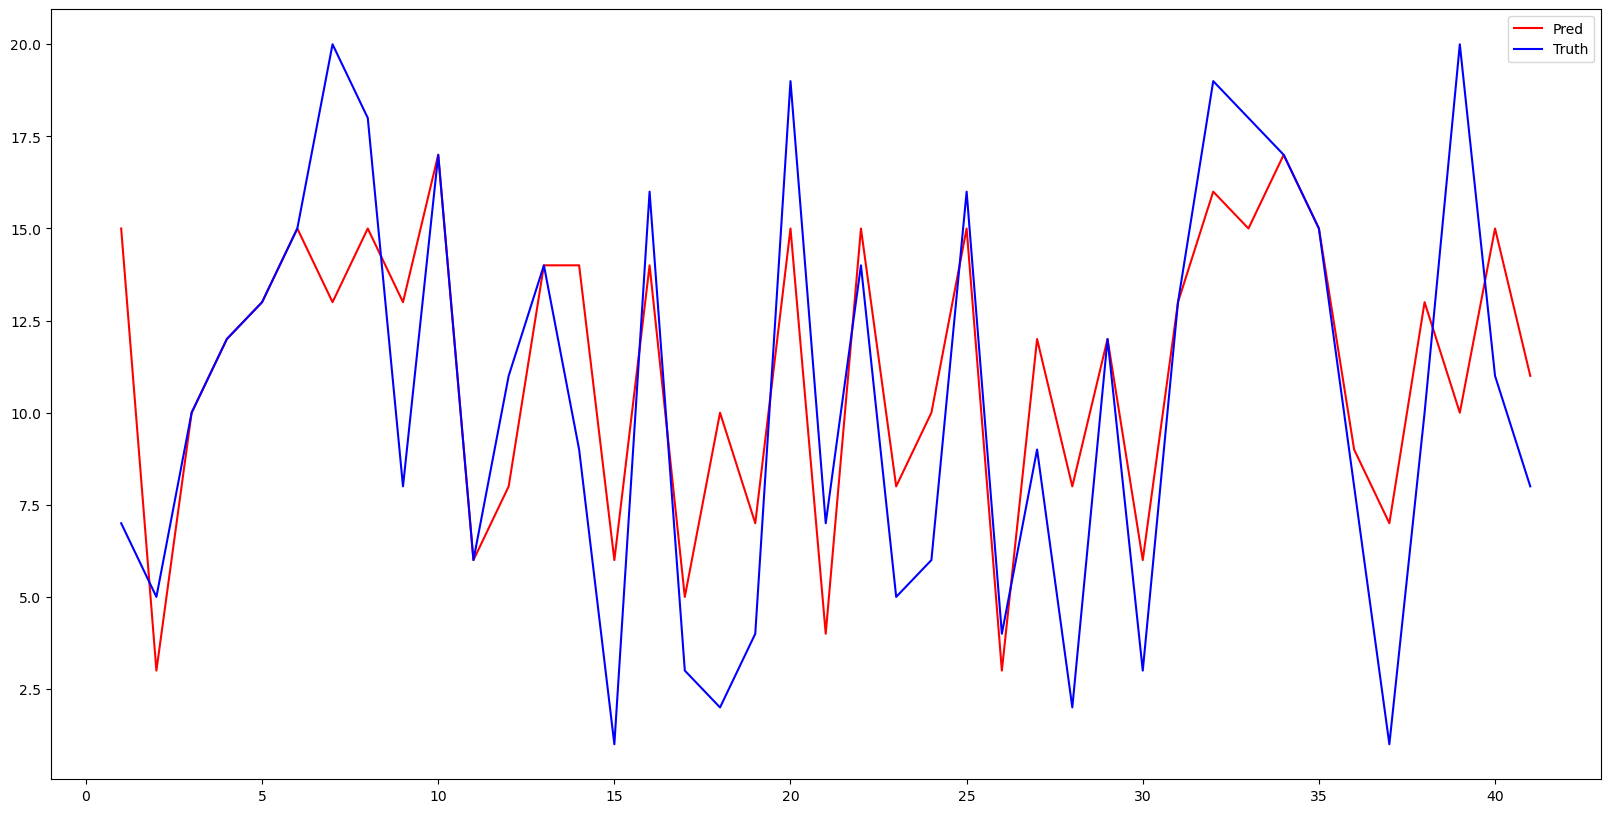

In [1832]:
plot_pred_vs_truth(val_copy,41,'line')

In [1798]:
# Check if we can overfit on the training data to ensure that the model is learning.
y_pred = rf.predict(x_trn)
get_rf_metrics(y_pred,y_trn)

Accuracy (exact position match): 0.304
Mean absolute error in positions: 1.222
Confusion matrix:
 [[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 29 14  5  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12 19 15  5  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11 25 10  6  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 18 17  9  5  1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 19 21  6  5  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3 21 21  8  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  6 17 13 12  3  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7 17 10 15  4  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  5 11 16 14  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 19 25  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3 19 25  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  4 17 29  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 11 21 